## 판다스로 채널별 일자별 분석


### 1. 데이터 불러오기

In [150]:
# 작성한 쿼리로 판다스로 불러옵니다.
query = '''
select date, trafficSource.source, trafficSource.medium,
    count(d.visitId) as visit, 
    count(transaction.transactionId) as purchase,
    sum(prod.ProductRevenue)/power(10, 6) as revenue,
from `bigquery-public-data.google_analytics_sample.ga_sessions_*` as d
    left join unnest(hits) as hits
    left join unnest(hits.product) as prod
where _table_suffix between  '20170701' and '20170731'
group by date, trafficSource.source, trafficSource.medium
order by date
'''
df = pd.read_gbq(query = query, dialect = 'standard',project_id = "public-data-projects")

In [151]:
# 그래프 스타일 ggplot설정
plt.style.use("ggplot")

In [152]:
# 데이터 미리보기
print(df.shape)
df.head()

(1021, 6)


,date,source,medium,visit,purchase,revenue
0,20170701,(direct),(none),6973,0,NaN
1,20170701,bing,organic,25,0,NaN
2,20170701,qiita.com,referral,29,0,NaN
3,20170701,blog.golang.org,referral,18,0,NaN
4,20170701,google.com,referral,177,0,NaN


### 2. 전처리

In [153]:
# 결측치 확인
# 유입경로별로 수익이 없는 곳도 있어 revenue에 NaN이 많습니다.
df.isna().sum()

date          0
source        0
medium        0
visit         0
purchase      0
revenue     902
dtype: int64

In [154]:
# revenue의 NaN을 0으로 변경 후 결측치를 다시 확인합니다.
df.loc[df['revenue'].isna(), 'revenue'] = 0
df.isna().sum()

date        0
source      0
medium      0
visit       0
purchase    0
revenue     0
dtype: int64

### 3. 마케팅 채널 별 분석

In [155]:
# 7월 전체 데이터를 보기 위해 유입채널만으로 다시 집계합니다.
df_july = df.groupby(['source', 'medium'])[['visit','purchase','revenue']].sum().reset_index()
print(df_july.shape)
df_july.head()

(102, 5)


,source,medium,visit,purchase,revenue
0,(direct),(none),429149,4770,127001.799579
1,(direct),cpm,1,0,0.000000
2,Partners,affiliate,20494,34,517.709996
3,adwords.google.com,referral,270,0,0.000000
4,amp.reddit.com,referral,15,0,0.000000


In [156]:
# revenue는 소수점 2자리에서 반올림 해줍니다.
df_july['revenue'] = round(df_july['revenue'], 2)
df_july['revenue'].head()

0    127001.80
1         0.00
2       517.71
3         0.00
4         0.00
Name: revenue, dtype: float64

In [157]:
# 방문자순으로 소팅해 합니다.
df_visit10 = df_july.sort_values('visit', ascending = False).head(10)
df_visit10['channel'] = df_visit10['source'] + '_' +  df_visit10['medium']
df_visit10

,source,medium,visit,purchase,revenue,channel
30,google,organic,684969,2010,26852.76,google_organic
0,(direct),(none),429149,4770,127001.80,(direct)_(none)
101,youtube.com,referral,105309,2,8.49,youtube.com_referral
28,google,cpc,47799,320,3787.44,google_cpc
2,Partners,affiliate,20494,34,517.71,Partners_affiliate
5,analytics.google.com,referral,17391,0,0.00,analytics.google.com_referral
29,google,cpm,8346,90,1315.16,google_cpm
19,dfa,cpm,6902,50,449.14,dfa_cpm
59,m.facebook.com,referral,6825,2,5.99,m.facebook.com_referral
38,google.com,referral,4849,0,0.00,google.com_referral


<AxesSubplot:ylabel='channel'>

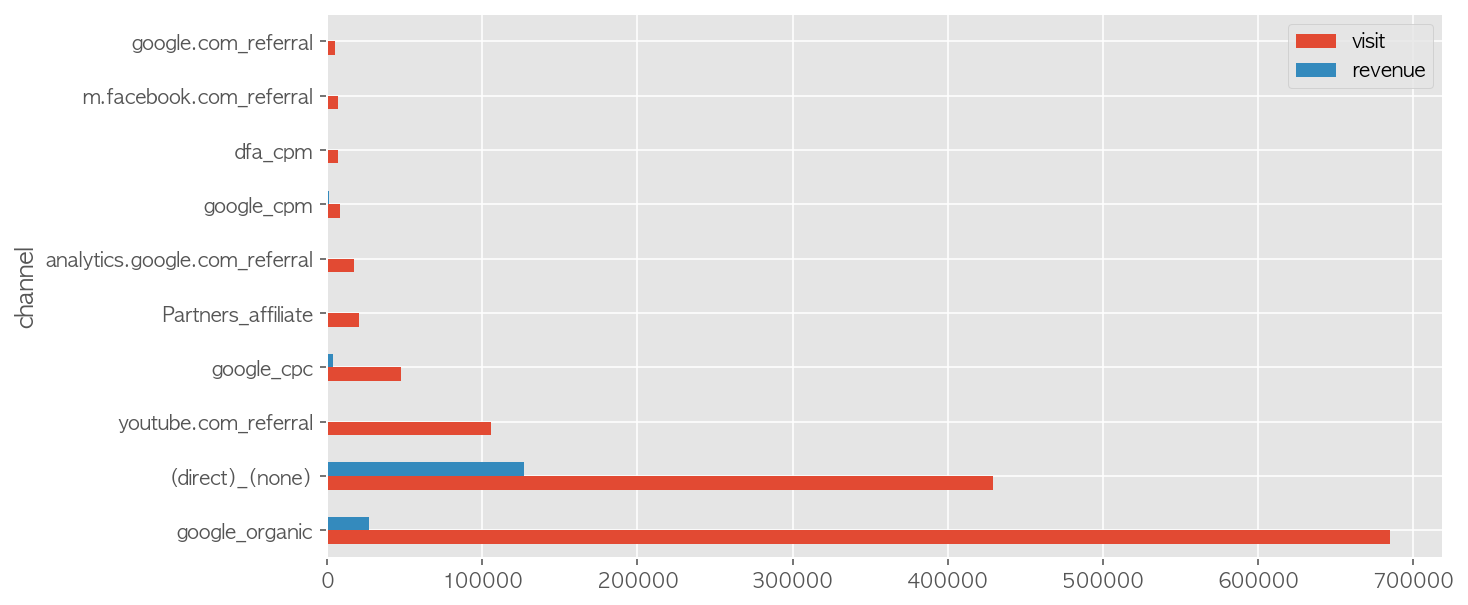

In [158]:
# 채널별 방문자 & 수익으로 시각화 해봅니다.
# google_organic은 방문자는 가장 많지만 수익이 그에 비례해보이지는 않습니다.
# utm이 따로 찍히지 않은 (direct)_(none)이 가장 수익이 높습니다.
df_visit10.plot.barh(x = 'channel', y =['visit','revenue'], figsize = (10,5))

In [159]:
# 위 그래프 만으로는 어떤 채널이 유효한지 알 수 없습니다.
# 더 명확하게 보기위해 df_july에 구매 전환율 칼럼을 추가해줍니다. 
# 100을 곱해 % 단위로 보고 소수점 2자리까지만 표기합니다.
df_july['purchase_rate'] = round(df_july['purchase']/df_july['visit']*100, 2)
df_july.head()

,source,medium,visit,purchase,revenue,purchase_rate
0,(direct),(none),429149,4770,127001.80,1.11
1,(direct),cpm,1,0,0.00,0.00
2,Partners,affiliate,20494,34,517.71,0.17
3,adwords.google.com,referral,270,0,0.00,0.00
4,amp.reddit.com,referral,15,0,0.00,0.00


In [160]:
# 구매전환율 순으로 소팅합니다.
# outlook과 gmail이 0번 3번행에 보입니다. 
    # 현 utm으로는 유료 이메일광고는 안보이는데, 이메일 마케팅을 시작해본다면 유효할 수 있겠습니다.
# 그 외로 cpm, cpc광고가 눈에 들어옵니다. 다른 채널에 비해 구매전환율이 높습니다. 
    # 캠페인 단위로 드릴다운하여, 효율을 이끌어내는 캠페인을 발굴 할 수 있겠습니다.
df_july.sort_values('purchase_rate', ascending = False).head(10)

,source,medium,visit,purchase,revenue,purchase_rate
75,outlook.live.com,referral,51,2,32.99,3.92
15,calendar.google.com,referral,175,6,55.24,3.43
91,sites.google.com,referral,3227,50,490.96,1.55
64,mail.google.com,referral,2215,28,185.63,1.26
0,(direct),(none),429149,4770,127001.80,1.11
29,google,cpm,8346,90,1315.16,1.08
19,dfa,cpm,6902,50,449.14,0.72
28,google,cpc,47799,320,3787.44,0.67
100,yahoo,organic,2314,14,153.61,0.61
13,bing,organic,2143,8,52.94,0.37


In [161]:
df_july['medium'].unique()

array(['(none)', 'cpm', 'affiliate', 'referral', 'organic', 'cpc',
       '(not set)'], dtype=object)

In [162]:
# cpc와 cpm만 포함하는 행을 paid 칼럼을 통해 구분해줍니다.
df_july['paid'] = df_july['medium'].isin(['cpc','cpm'])
df_july[df_july['paid']== True]

,source,medium,visit,purchase,revenue,purchase_rate,paid
1,(direct),cpm,1,0,0.00,0.00,True
12,bing,cpc,2,0,0.00,0.00,True
19,dfa,cpm,6902,50,449.14,0.72,True
28,google,cpc,47799,320,3787.44,0.67,True
29,google,cpm,8346,90,1315.16,1.08,True


<AxesSubplot:xlabel='paid', ylabel='revenue'>

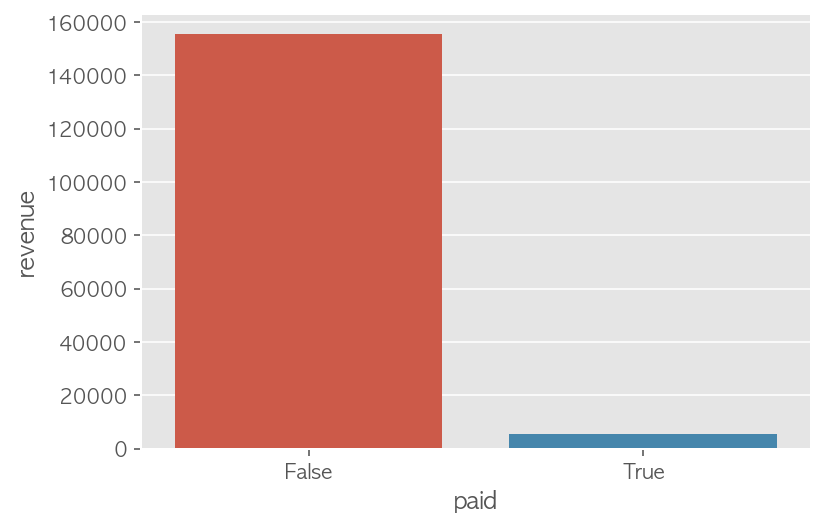

In [163]:
# 바플롯을 통해 유료광고와 비유료광고의 수익차이를 시각화 해봅니다.
# 비유료광고가 훨씬 높습니다.
sns.barplot(data = df_july, x = 'paid', y = 'revenue', estimator = sum, ci = None)

<AxesSubplot:xlabel='medium', ylabel='revenue'>

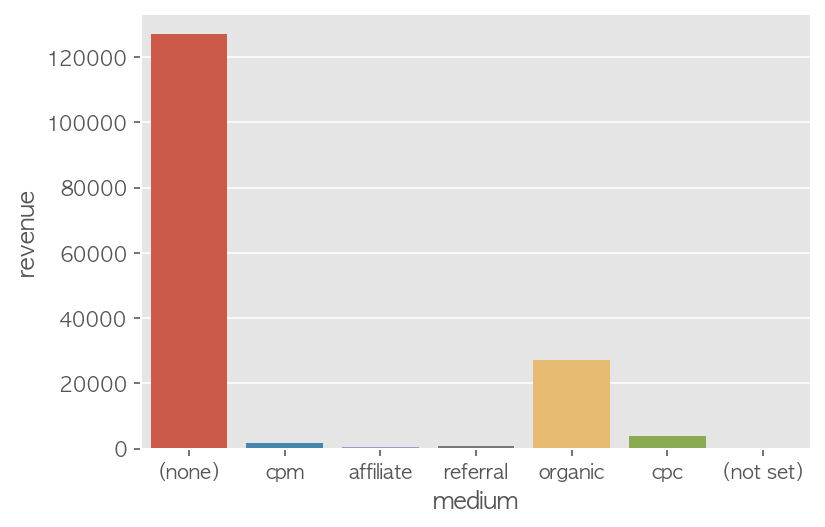

In [164]:
# 전체 medium값을 통해 분류해서 봅니다. none의 값이 너무 높아 다른 채널의 비교가 어렵습니다.
sns.barplot(data = df_july, x = 'medium', y = 'revenue',estimator = sum, ci = None)

<AxesSubplot:xlabel='medium', ylabel='revenue'>

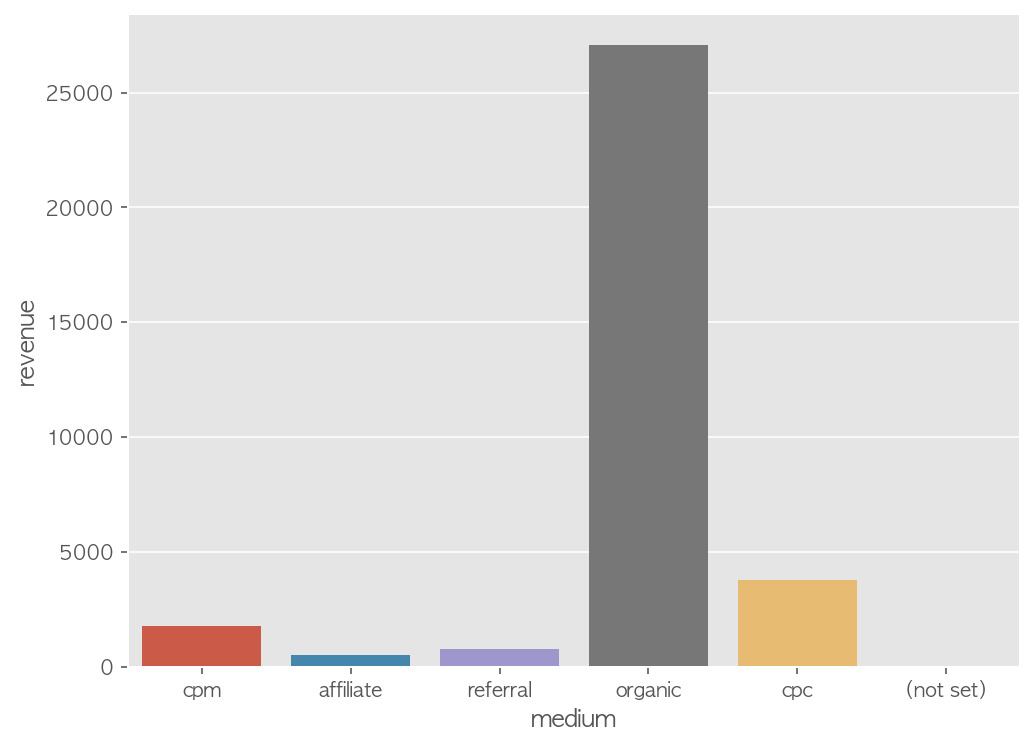

In [165]:
# (none)값을 제외하고 크기를 키웁니다.
# 아직 organic이 가장 높습니다. 상대적으로 유료광고의 비중이 적어보입니다.
plt.figure(figsize = (8,6))
sns.barplot(data = df_july[df_july['medium'] != '(none)'],
            x = 'medium', y = 'revenue',
            estimator = sum, ci = None)

#### 인사이트
- 현 매출 중 유료광고의 비중이 상대적으로 작음
- 유료광고 매출비중을 끌어올려 매출을 증진시킬 수 있어보임
    - 전환률이 잘 나오는 cpc, cpm광고 캠페인을 발굴해서 더 적극적으로 마케팅 실행
    - 이메일로 들어오는 트래픽의 전환률이 높은데 이메일 광고 가능성이 보임

### 4. 일자 별 분석

In [166]:
# 매출을 일자별로 집계합니다.
df_date = df.groupby(['date'])[['visit', 'purchase','revenue']].sum()
df_date.head()

,visit,purchase,revenue
date,,,
20170701,36347,12,100.540000
20170702,32197,40,678.989996
20170703,34458,92,1331.419996
20170704,30350,60,416.979994
20170705,49330,306,8254.529985


<AxesSubplot:xlabel='date', ylabel='revenue'>

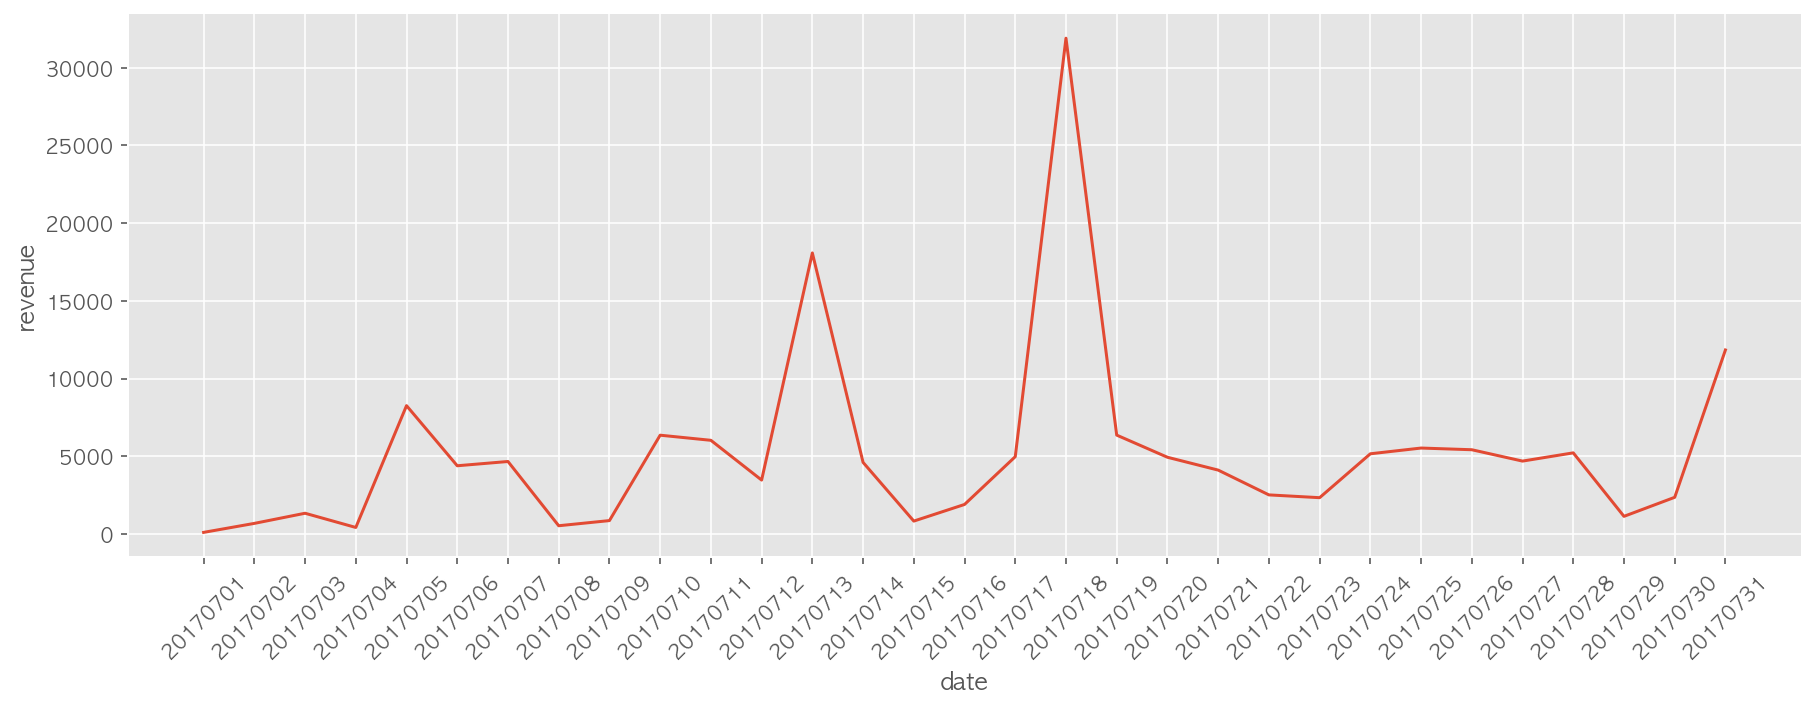

In [167]:
# 라인플롯으로 시각화 합니다. 7월 18일에 매출이 급증하였습니다.
plt.figure(figsize = (15,5))
plt.xticks(rotation = 45)
sns.lineplot(data = df_date, x = 'date' ,y = 'revenue')

In [168]:
# 7월 18일 데이터만 필터링해서 마케팅 채널별로 보니 (direct) (none)이 가장 많습니다.
df[df['date'] == '20170718'].sort_values('revenue', ascending = False).head()

,date,source,medium,visit,purchase,revenue
557,20170718,(direct),(none),17710,158,29462.829978
568,20170718,google,organic,28789,150,2129.239994
546,20170718,google,cpm,611,6,191.180000
558,20170718,google,cpc,1585,12,64.850000
559,20170718,yahoo,organic,117,4,46.980000


In [169]:
# 날짜별로 구매율 변동을 보기위해 df_date에 구매 전환율 칼럼을 만들어 줍니다.
df_date['purchase_rate'] = round(df_date['purchase']/df_date['visit'] * 100, 2)
df_date.head()

,visit,purchase,revenue,purchase_rate
date,,,,
20170701,36347,12,100.540000,0.03
20170702,32197,40,678.989996,0.12
20170703,34458,92,1331.419996,0.27
20170704,30350,60,416.979994,0.20
20170705,49330,306,8254.529985,0.62


<AxesSubplot:xlabel='date', ylabel='purchase_rate'>

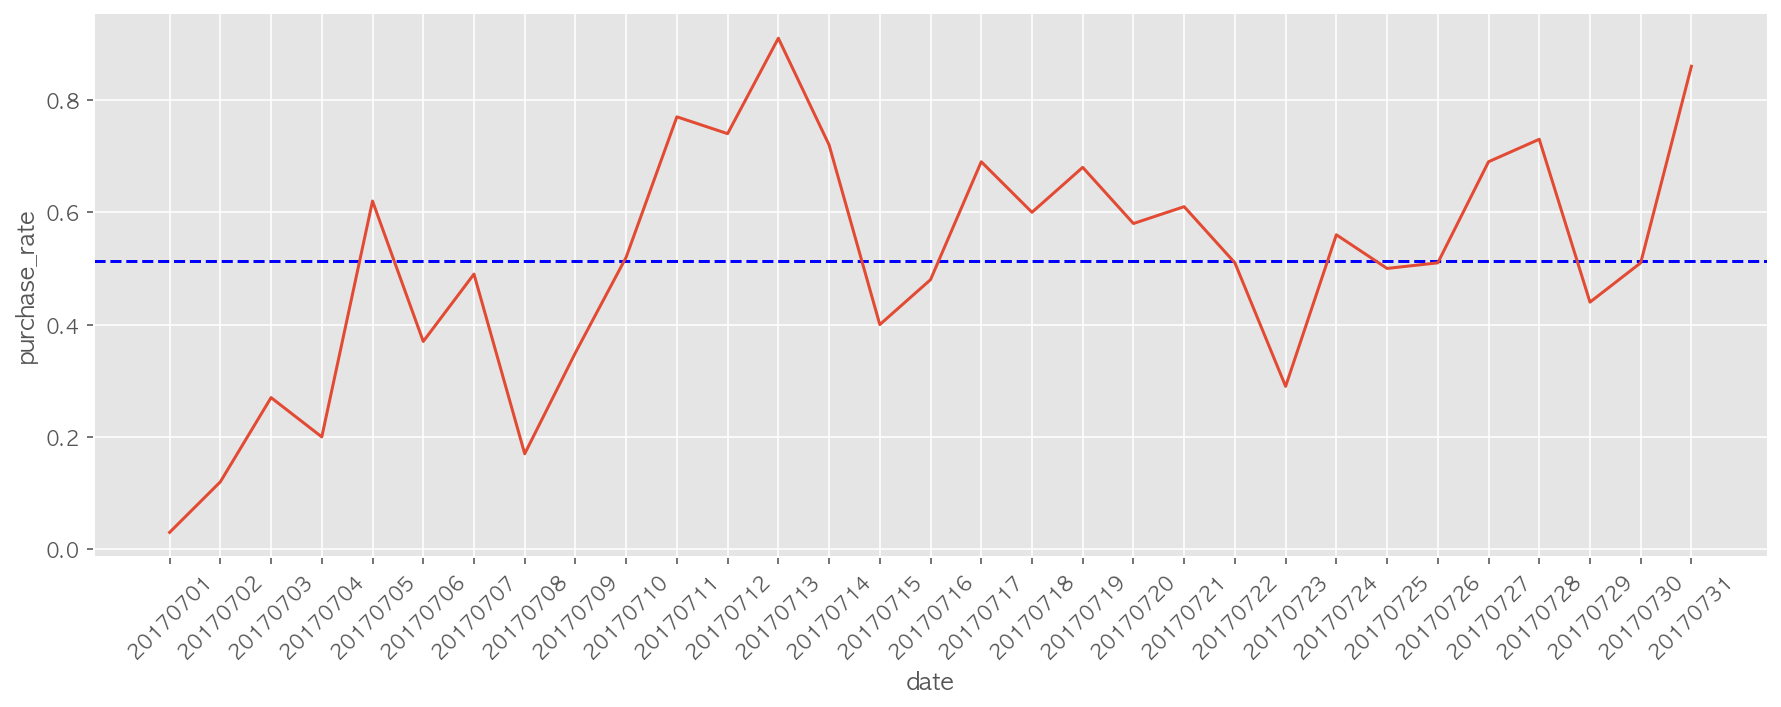

In [170]:
# 라인플롯으로 시각화 합니다. 7월 18일의 구매 전환율은 평균보다 약간 높은 수준입니다.
plt.figure(figsize = (15,5))
plt.xticks(rotation = 45)
plt.axhline(y=df_date['purchase_rate'].mean(), color='b', ls = '--')

sns.lineplot(data = df_date, x = 'date' ,y = 'purchase_rate')

<AxesSubplot:xlabel='date', ylabel='visit'>

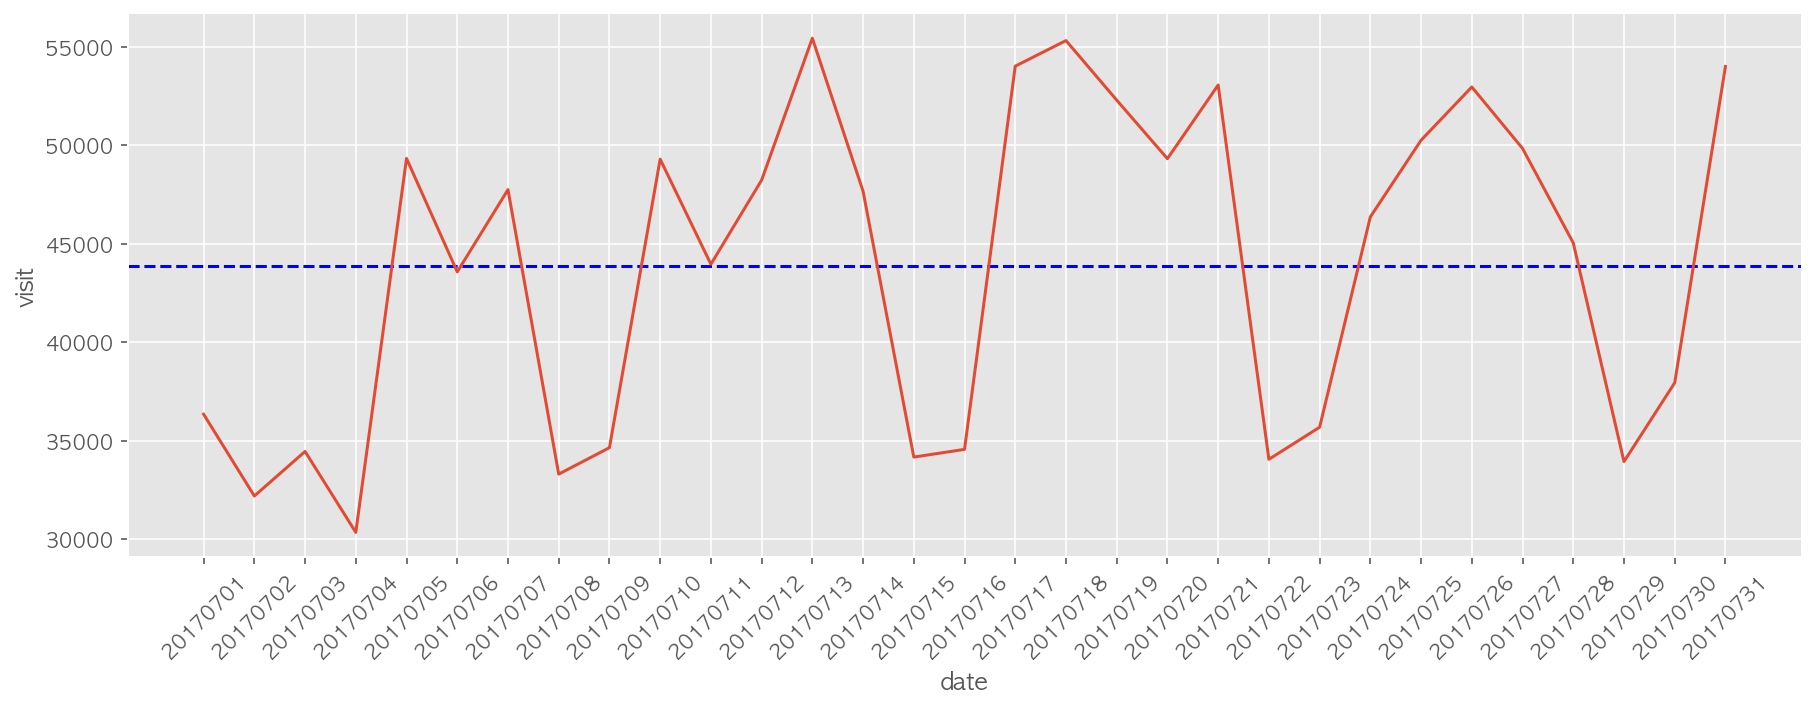

In [171]:
# 7월 18일의 방문자는 평균보다는 높은 수준이나 매출처럼 비교되게 높지는 않습니다.
plt.figure(figsize = (15,5))
plt.xticks(rotation = 45)
plt.axhline(y=df_date['visit'].mean(), color='b', ls = '--')

sns.lineplot(data = df_date, x = 'date' ,y = 'visit')

#### 인사이트
- 일자별 매출에서 7월 18일에 매출이 급증한 것을 확인
- 구매 전환률이나 일자별 방문자 수에서 특별한 점을 찾지 못함
- 해당 날짜에 특정 구매자들이 높은 금액의 주문을 한 것이 아닌가 추정됨
- 7월 18일의 결제정보와 해당 구매자들의 사용자 특성을 분석하면 추가 인사이트가 나올 것 같아 추가분석 필요